# SOLOv2

Segmenting Object by Locations (SOLO) is a family of anchor-free instance segmentation work flows. Traditionally, instance segmentation heavily built on anchor-based prior works such as Faster-RCNN and Mask-RCNN.  SOLO, on the other hand, proposed a new angle to the instance segmentation problem. 

The core idea of SOLO is very similar to YOLO: dividing the image into several sub-regions so that each sub-region will handle the segmentation of object that falls into the region.  This idea has been pursued by researchers for many years, however, there are many challenges that come with it:
* How does it handle segmentation of objects that fall into same region?
* How to provide a sense of location to the network?
* Segmenting on each sub-region is extremely resource demanding, especially memory. For example, if we divide the image into 40x40 grids, and each grid creates a mask. Then the final prediction size is __1600__ times of normal semantic segmentation.

What makes SOLOv2 successful is how it managed to address these challenges with simple and intuitive solutions. In this example, we will walk you through the details of SOLOv2. Here is a technical summary of SOLOv2:
* ___New Use of Feature Pyramid___: Feature Pyramid Network (FPN) is a network that can extract features from different stages of backbone. Normally people have been using FPN to assign objects of all sizes to all stages of network to improve performance. SOLO took different approach and leverages FPN to handle objects for different sizes. For example, smaller objects are assigned to early stages and larger objects will be assigned to later stages. This can effectively mitigate the `multiple objects same location` issue.


* __Location Encoding with Coordinate Padding__: In the classification and mask prediction, the feature will be concatenated by relative X and Y coordinates on the channel dimension to provide sense of location to the network. 


* __Dynamic Convolution for Mask__: Normally, a convolution operation has a pre-defined sizes of input, kernel and output. In dynamic convolution, only a subset kernel of interest will be selected and used to generate final results. This can greatly reduce the resource requirement needed, and it is what makes producing a mask from each sub-grid feasible.


* __Matrix NMS__: SOLO proposed a new matrix NMS methodology that is much more efficient and faster than other NMS approaches. This helps speed up the inferencing significantly.

Now let's get into the implementation. First let's import the necessary functions:

In [1]:
import os
import tempfile

import cv2
import numpy as np
import pycocotools.mask as mask_util
import tensorflow as tf
import tensorflow_addons as tfa
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from scipy.ndimage.measurements import center_of_mass
from tensorflow.keras import layers

import fastestimator as fe
from fastestimator.dataset.data import mscoco
from fastestimator.op.numpyop import Batch, Delete, NumpyOp, RemoveIf
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, LongestMaxSize, PadIfNeeded, Resize
from fastestimator.op.numpyop.univariate import ReadImage
from fastestimator.op.tensorop.loss import L2Regularizaton
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.op.tensorop.tensorop import LambdaOp, TensorOp
from fastestimator.schedule import EpochScheduler, cosine_decay
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.trace import Trace
from fastestimator.util import Suppressor, get_num_devices

In [2]:
data_dir = None
model_dir = tempfile.mkdtemp()
epochs=12
batch_size_per_gpu=4
train_steps_per_epoch=None
eval_steps_per_epoch=None
im_size=1344

## Pipeline

In this example we will use MSCOCO data. The images and masks will be resized to ensure target longest side, then padded as square size.  Horizontal flipping is the only data augmentation.

In [3]:
class MergeMask(NumpyOp):
    def forward(self, data, state):
        data = np.stack(data, axis=-1)
        return data


class GetImageSize(NumpyOp):
    def forward(self, data, state):
        height, width, _ = data.shape
        return np.array([height, width], dtype="int32")


class Gt2Target(NumpyOp):
    def __init__(self,
                 inputs,
                 outputs,
                 mode=None,
                 num_grids=[40, 36, 24, 16, 12],
                 scale_ranges=[[1, 96], [48, 192], [96, 384], [192, 768], [384, 2048]],
                 coord_sigma=0.05):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.num_grids = num_grids
        self.scale_ranges = scale_ranges
        self.coord_sigma = coord_sigma
        missing_category = [66, 68, 69, 71, 12, 45, 83, 26, 29, 30]
        category = [x for x in range(1, 91) if not x in missing_category]
        self.mapping = {k: v for k, v in zip(category, list(range(80)))}

    def forward(self, data, state):
        masks, bboxes = data
        bboxes = np.array(bboxes, dtype="float32")
        masks = np.transpose(masks, [2, 0, 1])  # (H, W, #objects) -> (#objects, H, W)
        masks, bboxes = self.remove_empty_gt(masks, bboxes)
        # 91 classes -> 80 classes that starts from 1
        classes = np.array([self.mapping[int(x[-1])] + 1 for x in bboxes], dtype=np.int32)
        widths, heights = bboxes[:, 2], bboxes[:, 3]
        gt_match = []  # number of objects x (grid_idx, height_idx, width_idx, exist)
        for width, height, mask in zip(widths, heights, masks):
            object_match = []
            object_scale = np.sqrt(width * height)
            center_h, center_w = center_of_mass(mask)
            for grid_idx, ((lower_scale, upper_scale), num_grid) in enumerate(zip(self.scale_ranges, self.num_grids)):
                grid_matched = (object_scale >= lower_scale) & (object_scale <= upper_scale)
                if grid_matched:
                    w_delta, h_delta = 0.5 * width * self.coord_sigma, 0.5 * height * self.coord_sigma
                    coord_h, coord_w = int(center_h / mask.shape[0] * num_grid), int(center_w / mask.shape[1] * num_grid)
                    # each object will have some additional area of effect
                    top_box_extend = max(0, int((center_h - h_delta) / mask.shape[0] * num_grid))
                    down_box_extend = min(num_grid - 1, int((center_h + h_delta) / mask.shape[0] * num_grid))
                    left_box_extend = max(0, int((center_w - w_delta) / mask.shape[1] * num_grid))
                    right_box_extend = min(num_grid - 1, int((center_w + w_delta) / mask.shape[1] * num_grid))
                    # make sure the additional area of effect is at most 1 grid more
                    top_box_extend = max(top_box_extend, coord_h - 1)
                    down_box_extend = min(down_box_extend, coord_h + 1)
                    left_box_extend = max(left_box_extend, coord_w - 1)
                    right_box_extend = min(right_box_extend, coord_w + 1)
                    object_match.extend([(grid_idx, y, x, 1) for y in range(top_box_extend, down_box_extend + 1)
                                         for x in range(left_box_extend, right_box_extend + 1)])
            gt_match.append(object_match)
        gt_match = self.pad_match(gt_match)  #num_object x num_matches x [grid_idx, heihght_idx, width_idx, exist]
        return gt_match, masks, classes

    def pad_match(self, gt_match):
        max_num_matches = max([len(match) for match in gt_match])
        for match in gt_match:
            match.extend([(0, 0, 0, 0) for _ in range(max_num_matches - len(match))])
        return np.array(gt_match, dtype="int32")

    def remove_empty_gt(self, masks, bboxes):
        num_objects = masks.shape[0]
        non_empty_mask = np.sum(masks.reshape(num_objects, -1), axis=1) > 0
        return masks[non_empty_mask], bboxes[non_empty_mask]


assert im_size % 32 == 0, "im_size must be a multiple of 32"
num_device = get_num_devices()
train_ds, val_ds = mscoco.load_data(root_dir=data_dir, load_masks=True)
batch_size = num_device * batch_size_per_gpu
pipeline = fe.Pipeline(
    train_data=train_ds,
    eval_data=val_ds,
    test_data=val_ds,
    ops=[
        ReadImage(inputs="image", outputs="image"),
        MergeMask(inputs="mask", outputs="mask"),
        GetImageSize(inputs="image", outputs="imsize", mode="test"),
        LongestMaxSize(max_size=im_size, image_in="image", mask_in="mask", bbox_in="bbox", bbox_params="coco"),
        RemoveIf(fn=lambda x: len(x) == 0, inputs="bbox"),
        PadIfNeeded(min_height=im_size,
                    min_width=im_size,
                    image_in="image",
                    mask_in="mask",
                    bbox_in="bbox",
                    bbox_params="coco",
                    border_mode=cv2.BORDER_CONSTANT,
                    value=0),
        Sometimes(HorizontalFlip(image_in="image", mask_in="mask", bbox_in="bbox", bbox_params="coco",
                                 mode="train")),
        Resize(height=im_size // 4, width=im_size // 4, image_in='mask'),  # downscale mask for memory efficiency
        Gt2Target(inputs=("mask", "bbox"), outputs=("gt_match", "mask", "classes")),
        Delete(keys="bbox"),
        Delete(keys="image_id", mode="!test"),
        Batch(batch_size=batch_size, pad_value=0)
    ],
    num_process=8 * num_device)

## Visualize the Ground Truth Matching

One critical step before training the neural network is to visually inspect the data generated by the pipeline. In this case, we will visualize how different objects are assigned to different grids at different feature level.

In [4]:
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker

def plot_overlay(image_resized, masks, match, num_grid, axe, grid_idx, mask_size):
    if num_grid is None:
        overall_mask = np.max(masks, axis=0)
    else:
        overall_mask = np.zeros_like(masks)
        for idx, (mask, mat) in enumerate(zip(masks, match)):
            mat = mat[np.sum(mat, -1) > 0]
            matched_grids = set(mat[:, 0])
            if grid_idx in matched_grids:
                overall_mask[idx] = mask
                matched_current_grid = mat[mat[:, 0] == grid_idx]
                for point in matched_current_grid:
                    y_coordinate = (point[1] + 0.5) * mask_size / num_grid
                    x_coordinate = (point[2] + 0.5) * mask_size / num_grid
                    axe.plot(x_coordinate, y_coordinate, 'bo')
        overall_mask = np.max(overall_mask, axis=0)
    overall_mask = np.uint8(np.where(overall_mask < 0.5, 0, 255))
    mask_rgb = cv2.cvtColor(overall_mask, cv2.COLOR_GRAY2RGB)
    mask_overlay = np.where(mask_rgb != [0, 0, 0], [255, 0, 0], [0, 0, 0])
    mask_overlay = mask_overlay.astype(np.uint8)
    img_with_mask = cv2.addWeighted(image_resized, 0.7, mask_overlay, 0.3, 0)
    if num_grid:
        axe.set_title("{} x {}".format(num_grid, num_grid))
        loc = plticker.MultipleLocator(base= mask_size / num_grid)
        axe.xaxis.set_major_locator(loc)
        axe.yaxis.set_major_locator(loc)
        axe.grid(which='major', axis='both', linestyle='-')
    axe.xaxis.set_ticklabels([])
    axe.yaxis.set_ticklabels([])
    axe.imshow(img_with_mask)

def display_pipeline(idx, image, mask, match):
    image, mask, match = image[idx], mask[idx], match[idx]
    num_grids = [None, 40, 36, 24, 16, 12]
    mask_size = mask.shape[-1]
    image_resized = cv2.resize(image, (mask_size, mask_size))
    mask_exist = [np.sum(m) > 0 for m in mask]
    mask = mask[mask_exist]
    match = match[mask_exist]
    _, axes = plt.subplots(1, 6, figsize=(25, 5))
    for idx, (axe, num_grid) in enumerate(zip(axes, num_grids)):
        plot_overlay(image_resized, mask, match, num_grid, axe, idx - 1, mask_size)
    plt.show()
    
sample_batch = pipeline.get_results()
image = sample_batch['image'].numpy()
mask = sample_batch['mask'].numpy()
gt_match = sample_batch['gt_match'].numpy()

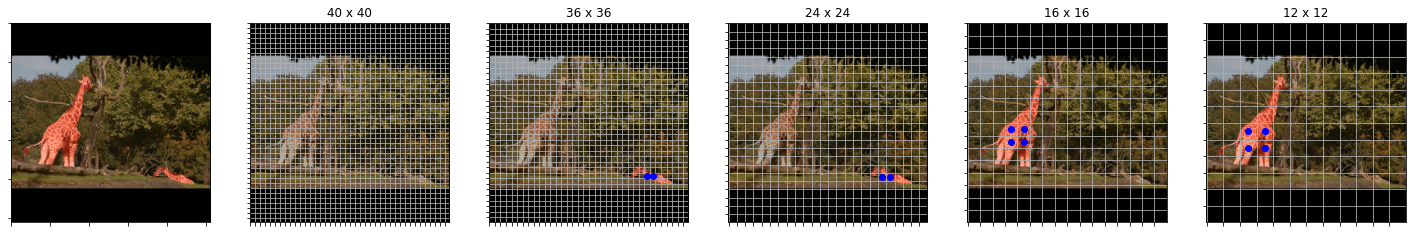

In [5]:
display_pipeline(1, image, mask, gt_match)

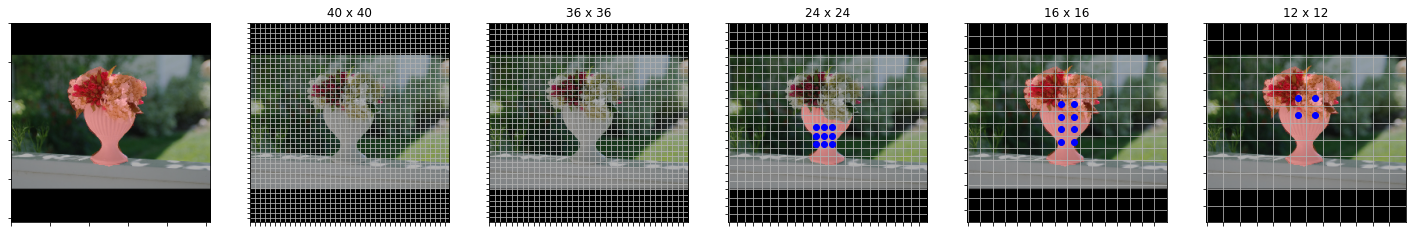

In [6]:
display_pipeline(2, image, mask, gt_match)

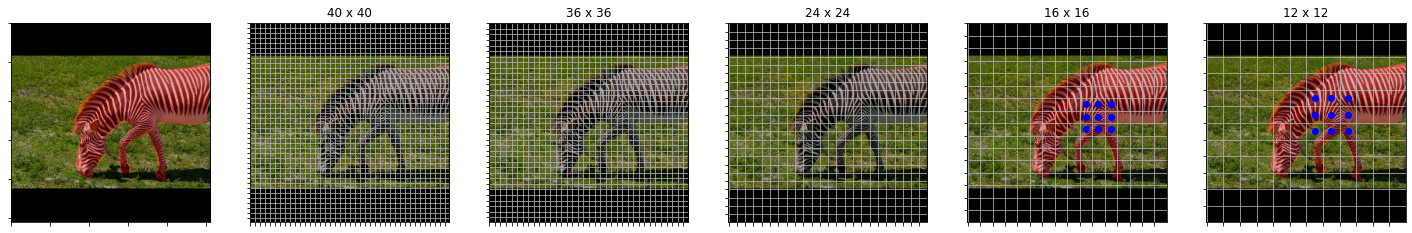

In [7]:
display_pipeline(3, image, mask, gt_match)

In figures above, the presence of blue dot represents the object being assigned to the grid location. To increase success, one object is often assigned to multiple grids at once. In addition, smaller grid cells are responsible for smaller objects, and large cells for larger objects. That's why zebras are only highlighted in 16x16 and 12x12 grids in the third figure.

## SOLOv2 model

The SOLOv2 model include the following component: Backbone, Feature Pyramid Net (Neck), classification head (for classification and creating mask kernels) , mask head (creating feature used to compute mask).

In [8]:
def fpn(C2, C3, C4, C5):
    # lateral conv
    P5 = layers.Conv2D(256, kernel_size=1)(C5)
    P5_up = layers.UpSampling2D()(P5)
    P4 = layers.Conv2D(256, kernel_size=1)(C4)
    P4 = P4 + P5_up
    P4_up = layers.UpSampling2D()(P4)
    P3 = layers.Conv2D(256, kernel_size=1)(C3)
    P3 = P3 + P4_up
    P3_up = layers.UpSampling2D()(P3)
    P2 = layers.Conv2D(256, kernel_size=1)(C2)
    P2 = P2 + P3_up
    # fpn conv
    P5 = layers.Conv2D(256, kernel_size=3, padding="same")(P5)
    P4 = layers.Conv2D(256, kernel_size=3, padding="same")(P4)
    P3 = layers.Conv2D(256, kernel_size=3, padding="same")(P3)
    P2 = layers.Conv2D(256, kernel_size=3, padding="same")(P2)
    return P2, P3, P4, P5


def pad_with_coord(data):
    data_shape = tf.shape(data)
    batch_size, height, width = data_shape[0], data_shape[1], data_shape[2]
    x = tf.cast(tf.linspace(-1, 1, num=width), data.dtype)
    x = tf.tile(x[tf.newaxis, tf.newaxis, ..., tf.newaxis], [batch_size, height, 1, 1])
    y = tf.cast(tf.linspace(-1, 1, num=height), data.dtype)
    y = tf.tile(y[tf.newaxis, ..., tf.newaxis, tf.newaxis], [batch_size, 1, width, 1])
    data = tf.concat([data, x, y], axis=-1)
    return data


def conv_norm(x, filters, kernel_size=3, groups=32):
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same', use_bias=False)(x)
    x = tfa.layers.GroupNormalization(groups=groups, epsilon=1e-5)(x)
    return x


def solov2_head_model(stacked_convs=4, ch_in=258, ch_feature=512, ch_kernel_out=256, num_classes=80):
    inputs = layers.Input(shape=(None, None, ch_in))
    feature_kernel = inputs
    feature_cls = inputs[..., :-2]
    for _ in range(stacked_convs):
        feature_kernel = tf.nn.relu(conv_norm(feature_kernel, filters=ch_feature))
        feature_cls = tf.nn.relu(conv_norm(feature_cls, filters=ch_feature))
    feature_kernel = layers.Conv2D(filters=ch_kernel_out,
                                   kernel_size=3,
                                   padding='same',
                                   kernel_initializer=tf.random_normal_initializer(stddev=0.01))(feature_kernel)
    feature_cls = layers.Conv2D(filters=num_classes,
                                kernel_size=3,
                                padding='same',
                                kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                bias_initializer=tf.initializers.constant(np.log(1 / 99)))(feature_cls)
    return tf.keras.Model(inputs=inputs, outputs=[feature_kernel, feature_cls])


def solov2_head(P2, P3, P4, P5, num_classes=80):
    head_model = solov2_head_model(num_classes=num_classes)
    # applying maxpool first for P2
    P2 = layers.MaxPool2D()(P2)
    features = [P2, P3, P4, P5, P5]
    grid_sizes = [40, 36, 24, 16, 12]
    feat_kernel_list, feat_cls_list = [], []
    for feature, grid_size in zip(features, grid_sizes):
        feature = pad_with_coord(feature)
        feature = tf.image.resize(feature, size=(grid_size, grid_size))
        feat_kernel, feat_cls = head_model(feature)
        feat_kernel_list.append(feat_kernel)
        feat_cls_list.append(tf.sigmoid(feat_cls))
    return feat_cls_list, feat_kernel_list


def solov2_maskhead(P2, P3, P4, P5, mid_ch=128, out_ch=256):
    # first level
    P2 = tf.nn.relu(conv_norm(P2, filters=mid_ch))
    # second level
    P3 = tf.nn.relu(conv_norm(P3, filters=mid_ch))
    P3 = layers.UpSampling2D()(P3)
    # third level
    P4 = tf.nn.relu(conv_norm(P4, filters=mid_ch))
    P4 = layers.UpSampling2D()(P4)
    P4 = tf.nn.relu(conv_norm(P4, filters=mid_ch))
    P4 = layers.UpSampling2D()(P4)
    # top level, add coordinate
    P5 = tf.nn.relu(conv_norm(pad_with_coord(P5), filters=mid_ch))
    P5 = layers.UpSampling2D()(P5)
    P5 = tf.nn.relu(conv_norm(P5, filters=mid_ch))
    P5 = layers.UpSampling2D()(P5)
    P5 = tf.nn.relu(conv_norm(P5, filters=mid_ch))
    P5 = layers.UpSampling2D()(P5)
    seg_outputs = tf.nn.relu(conv_norm(P2 + P3 + P4 + P5, filters=out_ch, kernel_size=1))
    return seg_outputs


def solov2(input_shape=(None, None, 3), num_classes=80):
    inputs = tf.keras.Input(shape=input_shape)
    resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=inputs, pooling=None)
    assert resnet50.layers[38].name == "conv2_block3_out"
    C2 = resnet50.layers[38].output
    assert resnet50.layers[80].name == "conv3_block4_out"
    C3 = resnet50.layers[80].output
    assert resnet50.layers[142].name == "conv4_block6_out"
    C4 = resnet50.layers[142].output
    assert resnet50.layers[-1].name == "conv5_block3_out"
    C5 = resnet50.layers[-1].output
    P2, P3, P4, P5 = fpn(C2, C3, C4, C5)
    feat_seg = solov2_maskhead(P2, P3, P4, P5)  # [B, h/4, w/4, 256]
    feat_cls_list, feat_kernel_list = solov2_head(P2, P3, P4, P5, num_classes=num_classes)  # [B, grid, grid, 80], [B, grid, grid, 256]
    model = tf.keras.Model(inputs=inputs, outputs=[feat_seg, feat_cls_list, feat_kernel_list])
    return model

init_lr = 1e-2 / 16 * batch_size
model = fe.build(model_fn=lambda: solov2(input_shape=(im_size, im_size, 3)),
                 optimizer_fn=lambda: tf.optimizers.SGD(learning_rate=init_lr, momentum=0.9))

## Training and Evaluation Network Operations

The loss of SOLOv2 is binary cross entropy for classification and dice loss for segmentation. Loss is calculated independently for each feature pyramid level, and finally combined together for training.  During evaluation, mask is dynamically calculated based on confidence score, and only the kernels corresponding to high enough confidence score will be used to produce masks.

In [9]:
class Normalize(TensorOp):
    def __init__(self, inputs, outputs, mean, std, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.mean = tf.convert_to_tensor(mean)
        self.std = tf.convert_to_tensor(std)

    def forward(self, data, state):
        data = (data / 255 - self.mean) / self.std
        return data


class Solov2Loss(TensorOp):
    def __init__(self, level, grid_dim, inputs, outputs, mode=None, num_class=80):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.level = level
        self.grid_dim = grid_dim
        self.num_class = num_class

    def forward(self, data, state):
        masks, classes, gt_match, feat_segs, feat_clss, kernels = data
        cls_loss, grid_object_maps = tf.map_fn(fn=lambda x: self.get_cls_loss(x[0], x[1], x[2]),
                             elems=(classes, feat_clss, gt_match),
                             fn_output_signature=(tf.float32, tf.float32))
        seg_loss = tf.map_fn(fn=lambda x: self.get_seg_loss(x[0], x[1], x[2], x[3]),
                             elems=(masks, feat_segs, kernels, grid_object_maps),
                             fn_output_signature=tf.float32)
        return cls_loss, seg_loss

    def get_seg_loss(self, mask, feat_seg, kernel, grid_object_map):
        indices = tf.where(grid_object_map[..., 0] > 0)
        object_indices = tf.cast(tf.gather_nd(grid_object_map, indices)[:, 1], tf.int32)
        mask_gt = tf.cast(tf.gather(mask, object_indices), kernel.dtype)
        active_kernel = tf.gather_nd(kernel, indices)
        feat_seg = tf.reshape(tf.transpose(feat_seg, perm=[2, 0, 1]),
                              (tf.shape(kernel)[-1], -1))  # H/4,W/4,C->C,H/4,W/4
        seg_preds = tf.reshape(tf.matmul(active_kernel, feat_seg), tf.shape(mask_gt))
        loss = self.dice_loss(seg_preds, mask_gt)
        return loss

    def dice_loss(self, pred, gt):
        pred = tf.sigmoid(pred)
        a = tf.reduce_sum(pred * gt)
        b = tf.reduce_sum(pred * pred) + 0.001
        c = tf.reduce_sum(gt * gt) + 0.001
        dice = (2 * a) / (b + c)
        return 1 - tf.where(dice > 0, dice, 1)

    def get_cls_loss(self, cls_gt, feat_cls, match):
        cls_gt = tf.cast(cls_gt, feat_cls.dtype)
        match, cls_gt = match[cls_gt > 0], cls_gt[cls_gt > 0]  # remove the padded object
        feat_cls_gts_raw = tf.map_fn(fn=lambda x: self.assign_cls_feat(x[0], x[1]),
                                     elems=(match, cls_gt),
                                     fn_output_signature=tf.float32)
        grid_object_map = self.reduce_to_single_grid(feat_cls_gts_raw)
        feat_cls_gts = tf.one_hot(tf.cast(grid_object_map[..., 0], tf.int32), depth=self.num_class + 1)[..., 1:]
        cls_loss = self.focal_loss(feat_cls, feat_cls_gts)
        return cls_loss, grid_object_map

    def reduce_to_single_grid(self, feat_cls_gts_raw):
        feat_cls_gts = tf.zeros((self.grid_dim, self.grid_dim), dtype=feat_cls_gts_raw.dtype)
        object_idx = tf.zeros((self.grid_dim, self.grid_dim), dtype=feat_cls_gts_raw.dtype)
        num_obj = tf.shape(feat_cls_gts_raw)[0]
        for idx in range(num_obj):
            classes = feat_cls_gts_raw[idx]
            indexes = tf.cast(tf.where(classes > 0, idx, 0), classes.dtype)
            object_idx = object_idx + tf.where(feat_cls_gts == 0, indexes, tf.zeros_like(indexes))
            feat_cls_gts = feat_cls_gts + tf.where(feat_cls_gts == 0, classes, tf.zeros_like(classes))
        grid_object_map = tf.stack([feat_cls_gts, object_idx], axis=-1)
        return grid_object_map

    def focal_loss(self, pred, gt, alpha=0.25, gamma=2.0):
        pred, gt = tf.reshape(pred, (-1, 1)), tf.reshape(gt, (-1, 1))
        anchor_obj_count = tf.cast(tf.math.count_nonzero(gt), pred.dtype)
        alpha_factor = tf.ones_like(gt) * alpha
        alpha_factor = tf.where(tf.equal(gt, 1), alpha_factor, 1 - alpha_factor)
        focal_weight = tf.where(tf.equal(gt, 1), 1 - pred, pred)
        focal_weight = alpha_factor * focal_weight**gamma / (anchor_obj_count + 1)
        cls_loss = tf.losses.BinaryCrossentropy(reduction='sum')(gt, pred, sample_weight=focal_weight)
        return cls_loss

    def assign_cls_feat(self, grid_match_info, cls_gt_obj):
        match_bool = tf.logical_and(tf.reduce_sum(grid_match_info, axis=-1) > 0, grid_match_info[:, 0] == self.level)
        grid_match_info = grid_match_info[match_bool]
        grid_indices = grid_match_info[:, 1:3]
        num_indices = tf.shape(grid_indices)[0]
        feat_cls_gt = tf.scatter_nd(grid_indices, tf.fill([num_indices], cls_gt_obj), (self.grid_dim, self.grid_dim))
        return feat_cls_gt


class CombineLoss(TensorOp):
    def forward(self, data, state):
        l_c1, l_s1, l_c2, l_s2, l_c3, l_s3, l_c4, l_s4, l_c5, l_s5 = data
        cls_losses = tf.reduce_sum(tf.stack([l_c1, l_c2, l_c3, l_c4, l_c5], axis=-1), axis=-1)
        seg_losses = tf.reduce_sum(tf.stack([l_s1, l_s2, l_s3, l_s4, l_s5], axis=-1), axis=-1)
        mean_cls_loss, mean_seg_loss = tf.reduce_mean(cls_losses), tf.reduce_mean(seg_losses) * 3
        return mean_cls_loss + mean_seg_loss, mean_cls_loss, mean_seg_loss


class PointsNMS(TensorOp):
    def forward(self, data, state):
        feat_cls_list = [self.points_nms(x) for x in data]
        return feat_cls_list

    def points_nms(self, x):
        x_max_pool = tf.nn.max_pool2d(x, ksize=2, strides=1, padding=[[0, 0], [1, 1], [1, 1], [0, 0]])[:, :-1, :-1, :]
        x = tf.where(tf.equal(x, x_max_pool), x, 0)
        return x


class Predict(TensorOp):
    def __init__(self, inputs, outputs, mode=None, score_threshold=0.1, segm_strides=[8.0, 8.0, 16.0, 32.0, 32.0]):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.score_threshold = score_threshold
        self.segm_strides = segm_strides

    def forward(self, data, state):
        feat_seg, feat_cls_list, feat_kernel_list = data
        strides = [tf.fill((tf.shape(x)[1] * tf.shape(x)[2], ), s) for s, x in zip(self.segm_strides, feat_cls_list)]
        batch_size, num_class = tf.shape(feat_cls_list[0])[0], tf.shape(feat_cls_list[0])[3]
        kernel_dim = tf.shape(feat_kernel_list[0])[-1]
        feat_cls = tf.concat([tf.reshape(x, (batch_size, -1, num_class)) for x in feat_cls_list], axis=1)
        feat_kernel = tf.concat([tf.reshape(x, (batch_size, -1, kernel_dim)) for x in feat_kernel_list], axis=1)
        strides = tf.concat(strides, axis=0)
        seg_preds, cate_scores, cate_labels  = tf.map_fn(fn=lambda x: self.predict_sample(x[0], x[1], x[2], strides),
                             elems=(feat_cls, feat_seg, feat_kernel),
                             fn_output_signature=(tf.float32, tf.float32, tf.int32))
        return seg_preds, cate_scores, cate_labels

    def predict_sample(self, cate_preds, seg_preds, kernel_preds, strides):
        # first filter class prediction by score_threshold
        select_indices = tf.where(cate_preds > self.score_threshold)
        cate_labels = tf.cast(select_indices[:, 1], tf.int32)
        kernel_preds = tf.gather(kernel_preds, select_indices[:, 0])
        cate_scores = tf.gather_nd(cate_preds, select_indices)
        strides = tf.gather(strides, select_indices[:, 0])
        # next calculate the mask
        kernel_preds = tf.transpose(kernel_preds)[tf.newaxis, tf.newaxis, ...]  # [k_h, k_w, c_in, c_out]
        seg_preds = tf.sigmoid(tf.nn.conv2d(seg_preds[tf.newaxis, ...], kernel_preds, strides=1, padding="VALID"))[0]
        seg_preds = tf.transpose(seg_preds, perm=[2, 0, 1])  # [C, H, W]
        seg_masks = tf.where(seg_preds > 0.5, 1.0, 0.0)
        # then filter masks based on strides
        mask_sum = tf.reduce_sum(seg_masks, axis=[1, 2])
        select_indices = tf.where(mask_sum > strides)[:, 0]
        seg_preds, seg_masks = tf.gather(seg_preds, select_indices), tf.gather(seg_masks, select_indices)
        mask_sum = tf.gather(mask_sum, select_indices)
        cate_labels, cate_scores = tf.gather(cate_labels, select_indices), tf.gather(cate_scores, select_indices)
        # scale the category score by mask confidence then matrix nms
        mask_scores = tf.reduce_sum(seg_preds * seg_masks, axis=[1, 2]) / mask_sum
        cate_scores = cate_scores * mask_scores
        seg_preds, cate_scores, cate_labels = self.matrix_nms(seg_preds, seg_masks, cate_labels, cate_scores, mask_sum)
        return seg_preds, cate_scores, cate_labels

    def matrix_nms(self, seg_preds, seg_masks, cate_labels, cate_scores, mask_sum, pre_nms_k=500, post_nms_k=100):
        # first select top k category scores
        num_selected = tf.minimum(pre_nms_k, tf.shape(cate_scores)[0])
        indices = tf.argsort(cate_scores, direction='DESCENDING')[:num_selected]
        seg_preds, seg_masks = tf.gather(seg_preds, indices), tf.gather(seg_masks, indices)
        cate_labels, cate_scores = tf.gather(cate_labels, indices), tf.gather(cate_scores, indices)
        mask_sum = tf.gather(mask_sum, indices)
        # calculate iou between different masks
        seg_masks = tf.reshape(seg_masks, shape=(num_selected, -1))
        intersection = tf.matmul(seg_masks, seg_masks, transpose_b=True)
        mask_sum = tf.tile(mask_sum[tf.newaxis, ...], multiples=[num_selected, 1])
        union = mask_sum + tf.transpose(mask_sum) - intersection
        iou = intersection / union
        iou = tf.linalg.band_part(iou, 0, -1) - tf.linalg.band_part(iou, 0, 0)  # equivalent of np.triu(diagonal=1)
        # iou decay and compensation
        labels_match = tf.tile(cate_labels[tf.newaxis, ...], multiples=[num_selected, 1])
        labels_match = tf.where(labels_match == tf.transpose(labels_match), 1.0, 0.0)
        labels_match = tf.linalg.band_part(labels_match, 0, -1) - tf.linalg.band_part(labels_match, 0, 0)
        decay_iou = iou * labels_match  # iou with any object from same class
        compensate_iou = tf.reduce_max(decay_iou, axis=0)
        compensate_iou = tf.tile(compensate_iou[..., tf.newaxis], multiples=[1, num_selected])
        # matrix nms
        decay_coefficient = tf.reduce_min(tf.exp(-2 * decay_iou**2) / tf.exp(-2 * compensate_iou**2), axis=0)
        cate_scores = cate_scores * decay_coefficient
        cate_scores = tf.where(cate_scores >= 0.05, cate_scores, 0)
        num_selected = tf.minimum(post_nms_k, tf.shape(cate_scores)[0])
        # select the final predictions and pad output for batch shape consistency
        indices = tf.argsort(cate_scores, direction='DESCENDING')[:num_selected]
        seg_preds = tf.pad(tf.gather(seg_preds, indices), paddings=[[0, post_nms_k - num_selected], [0, 0], [0, 0]])
        cate_scores = tf.pad(tf.gather(cate_scores, indices), paddings=[[0, post_nms_k - num_selected]])
        cate_labels = tf.pad(tf.gather(cate_labels, indices), paddings=[[0, post_nms_k - num_selected]])
        return seg_preds, cate_scores, cate_labels

network = fe.Network(ops=[
    Normalize(inputs="image", outputs="image", mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ModelOp(model=model, inputs="image", outputs=("feat_seg", "feat_cls_list", "feat_kernel_list")),
    LambdaOp(fn=lambda x: x, inputs="feat_cls_list", outputs=("cls1", "cls2", "cls3", "cls4", "cls5")),
    LambdaOp(fn=lambda x: x, inputs="feat_kernel_list", outputs=("k1", "k2", "k3", "k4", "k5")),
    Solov2Loss(0, 40, inputs=("mask", "classes", "gt_match", "feat_seg", "cls1", "k1"), outputs=("l_c1", "l_s1")),
    Solov2Loss(1, 36, inputs=("mask", "classes", "gt_match", "feat_seg", "cls2", "k2"), outputs=("l_c2", "l_s2")),
    Solov2Loss(2, 24, inputs=("mask", "classes", "gt_match", "feat_seg", "cls3", "k3"), outputs=("l_c3", "l_s3")),
    Solov2Loss(3, 16, inputs=("mask", "classes", "gt_match", "feat_seg", "cls4", "k4"), outputs=("l_c4", "l_s4")),
    Solov2Loss(4, 12, inputs=("mask", "classes", "gt_match", "feat_seg", "cls5", "k5"), outputs=("l_c5", "l_s5")),
    CombineLoss(inputs=("l_c1", "l_s1", "l_c2", "l_s2", "l_c3", "l_s3", "l_c4", "l_s4", "l_c5", "l_s5"),
                outputs=("total_loss", "cls_loss", "seg_loss")),
    L2Regularizaton(inputs="total_loss", outputs="total_loss_l2", model=model, beta=1e-5, mode="train"),
    UpdateOp(model=model, loss_name="total_loss_l2"),
    PointsNMS(inputs="feat_cls_list", outputs="feat_cls_list", mode="test"),
    Predict(inputs=("feat_seg", "feat_cls_list", "feat_kernel_list"),
            outputs=("seg_preds", "cate_scores", "cate_labels"),
            mode="test")
])

## Metrics and Learning Rate Scheduling

The evaluation metric of the task is mask mean average precision (mAP). The metric calculation takes a long time for the entire evaluation data, therefore it is only used during final testing phase after the training.  During the training, we use evaluation loss as metric.

The learning rate schedule is a combination of LR warm up and one-cycle cosine decay. The LR warm up is only applied in epoch 1 for the first 1000 steps, the one-cycle cosine decay starts at epoch 2.

In [10]:
def lr_schedule_warmup(step, init_lr):
    if step < 1000:
        lr = init_lr / 1000 * step
    else:
        lr = init_lr
    return lr


class COCOMaskmAP(Trace):
    def __init__(self, data_dir, inputs=None, outputs="mAP", mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        with Suppressor():
            self.coco_gt = COCO(os.path.join(data_dir.replace('val2017', 'annotations'), "instances_val2017.json"))
        missing_category = [66, 68, 69, 71, 12, 45, 83, 26, 29, 30]
        category = [x for x in range(1, 91) if not x in missing_category]
        self.mapping = {k: v for k, v in zip(list(range(80)), category)}

    def on_epoch_begin(self, data):
        self.results = []

    def on_batch_end(self, data):
        seg_preds, = data['seg_preds'].numpy(),
        cate_scores, cate_labels = data['cate_scores'].numpy(), data['cate_labels'].numpy()
        image_ids, imsizes = data['image_id'].numpy(), data['imsize'].numpy()
        for seg_pred, cate_score, cate_label, image_id, imsize in zip(seg_preds, cate_scores, cate_labels, image_ids, imsizes):
            # remove the padded data due to batching
            indices = cate_score > 0.01
            seg_pred, cate_score, cate_label = seg_pred[indices], cate_score[indices], cate_label[indices]
            if seg_pred.shape[0] == 0:
                continue
            seg_pred = np.transpose(seg_pred, axes=(1, 2, 0))  # [H, W, #objects]
            # remove the padded data due to image resize
            mask_h, mask_w, num_obj = seg_pred.shape
            image_h, image_w = 4 * mask_h, 4 * mask_w
            seg_pred = cv2.resize(seg_pred, (image_w, image_h))
            if num_obj == 1:
                seg_pred = seg_pred[..., np.newaxis]  # when there's only single object, resize will remove the channel
            ori_h, ori_w = imsize
            scale_ratio = min(image_h / ori_h, image_w / ori_w)
            pad_h, pad_w = image_h - scale_ratio * ori_h, image_w - scale_ratio * ori_w
            h_start, h_end = round(pad_h / 2), image_h - round(pad_h / 2)
            w_start, w_end = round(pad_w / 2), image_w - round(pad_w / 2)
            seg_pred = seg_pred[h_start:h_end, w_start:w_end, :]
            # now reshape to original shape
            seg_pred = cv2.resize(seg_pred, (ori_w, ori_h))
            if num_obj == 1:
                seg_pred = seg_pred[..., np.newaxis]  # when there's only single object, resize will remove the channel
            seg_pred = np.transpose(seg_pred, [2, 0, 1])  # [#objects, H, W]
            seg_pred = np.uint8(np.where(seg_pred > 0.5, 1, 0))
            for seg, score, label in zip(seg_pred, cate_score, cate_label):
                result = {
                    "image_id": image_id,
                    "category_id": self.mapping[label],
                    "score": score,
                    "segmentation": mask_util.encode(np.array(seg[..., np.newaxis], order='F'))[0]
                }
                self.results.append(result)
        return data

    def on_epoch_end(self, data):
        mAP = 0.0
        if self.results:
            with Suppressor():
                coco_results = self.coco_gt.loadRes(self.results)
                cocoEval = COCOeval(self.coco_gt, coco_results, 'segm')
                cocoEval.evaluate()
                cocoEval.accumulate()
                cocoEval.summarize()
                mAP = cocoEval.stats[0]
        data.write_with_log(self.outputs[0], mAP)


train_steps_epoch = int(np.ceil(len(train_ds) / batch_size))

lr_schedule = {
    1:
    LRScheduler(model=model, lr_fn=lambda step: lr_schedule_warmup(step, init_lr=init_lr)),
    2:
    LRScheduler(model=model, lr_fn=lambda step: cosine_decay(step,
                                        cycle_length=train_steps_epoch * (epochs - 1),
                                        init_lr=init_lr,
                                        min_lr=init_lr / 100,
                                        start=train_steps_epoch + 1))
}

traces = [
    EpochScheduler(lr_schedule),
    COCOMaskmAP(data_dir=val_ds.root_dir,
                inputs=("seg_preds", "cate_scores", "cate_labels", "image_id", "imsize"),
                mode="test"),
    BestModelSaver(model=model, save_dir=model_dir, metric="total_loss")
]

## Start Training

12 epochs of training with 1024 image size will take around __11 hours on 4 A100 GPUs__. If less GPU memory and computation budget are needed, you can reduce the `im_size` and `batch_per_gpu`.

After 12 epochs of training, the mAP can reach ~0.32mAP, setting the `epochs` to 36 will match paper's result(~0.34 mAP). 

In [ ]:
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         monitor_names=("cls_loss", "seg_loss", "total_loss"),
                         train_steps_per_epoch=train_steps_per_epoch,
                         eval_steps_per_epoch=eval_steps_per_epoch)
estimator.fit()

## Inferencing

After training the SOLOv2 model, let's visualize some sample predictions:

In [12]:
test_data = pipeline.get_results(mode="test")
images = test_data["image"].numpy()
test_data = network.transform(test_data, mode="test")
seg_preds = test_data['seg_preds'].numpy()
cate_scores = test_data['cate_scores'].numpy()
cate_labels = test_data['cate_labels'].numpy()

In [13]:
import random

def auto_color():
    rgbl=[255,0,0]
    random.shuffle(rgbl)
    return tuple(rgbl)


def visualize_test_results(idx, images, seg_preds, cate_scores, cate_labels, num_select=10):
    category_names = [
        'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',
        'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
        'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
        'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
        'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
        'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork',
        'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
        'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
        'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
        'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
        'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
        'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]
    category_id_to_name = {
        key: name
        for key, name in zip(range(80), category_names)
    }
    image, seg_preds = images[idx], seg_preds[idx][:num_select]
    cate_scores, cate_labels = cate_scores[idx][:num_select], cate_labels[idx][:num_select]
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    img_with_mask = image
    for seg_pred, cate_score, cate_label in zip(seg_preds, cate_scores, cate_labels):
        seg_pred = cv2.resize(seg_pred, (image.shape[1], image.shape[0]))
        mask = np.where(seg_pred > 0.5, 255, 0)
        mask = np.stack([mask, mask, mask], axis=-1)
        mask = np.uint8(np.where(mask != [0, 0, 0], auto_color(), img_with_mask))
        img_with_mask = cv2.addWeighted(img_with_mask, 0.5, mask, 0.5, 0)
        label_name = category_id_to_name[cate_label]
        center_y, center_x = center_of_mass(seg_pred)
        if not np.isnan(center_y) and not np.isnan(center_x):
            ax[1].text(int(center_x), int(center_y), label_name, color='white', fontsize=11)
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('Original')
    ax[1].imshow(img_with_mask)
    ax[1].axis('off')
    ax[1].set_title('Prediction')
    plt.show()

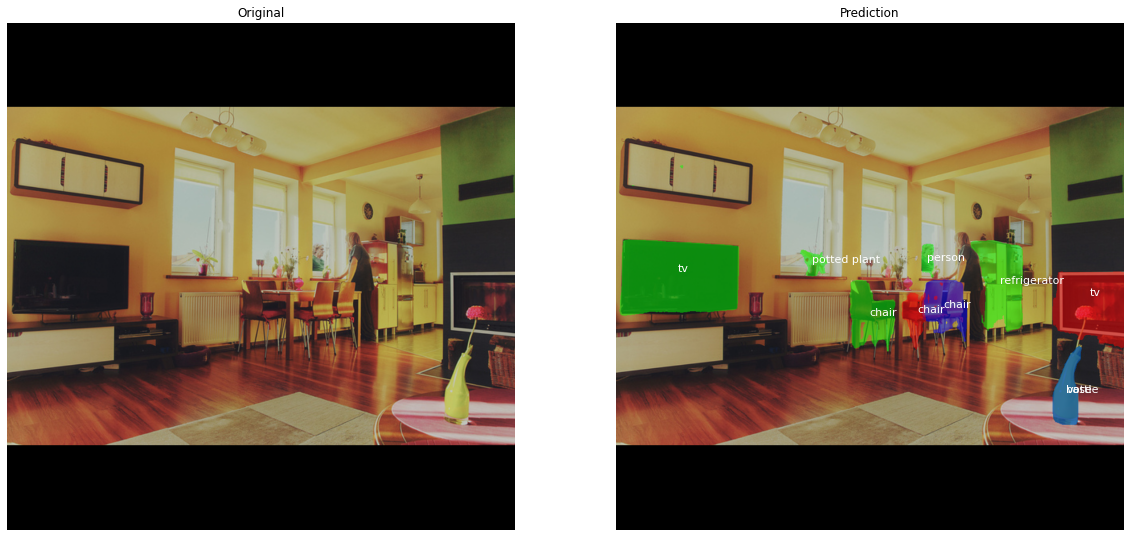

In [14]:
visualize_test_results(0, images, seg_preds, cate_scores, cate_labels)

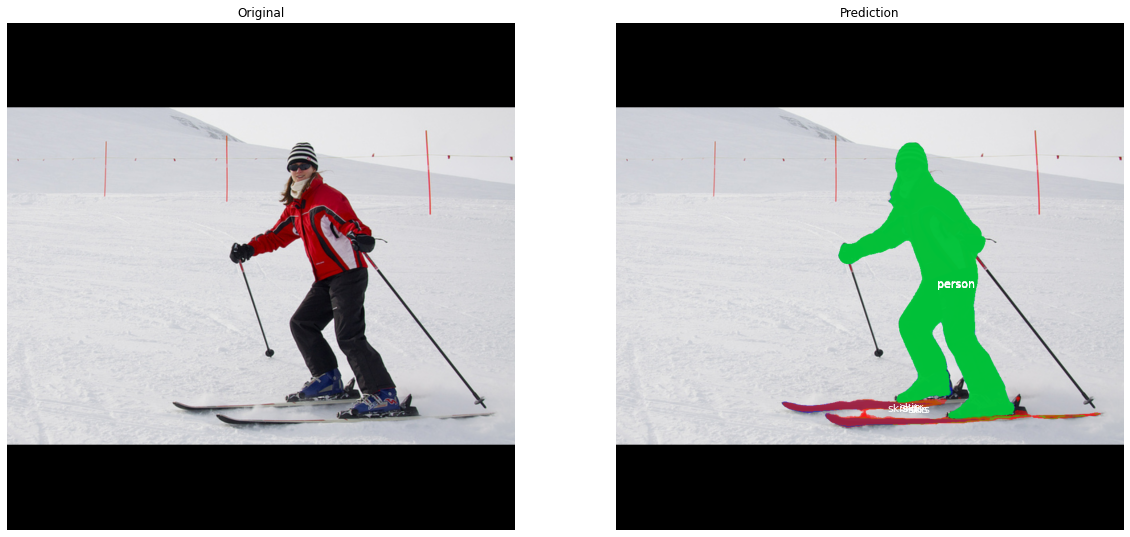

In [15]:
visualize_test_results(5, images, seg_preds, cate_scores, cate_labels)